Bitcoin ransomware detection

Features:

- The **address** is a public BC address which can receive and send bitcoins.        
- The **income** of an address $a$ is the total amount of coins output to it measured in Satoshis (1 millionth of a BC).
- The number of (in) **neighbors** of an address $a$  is the number of transactions which
have $a$ as one of its output addresses.
- The **weight** of an address is the sum of the fraction of *coins* that come from a starter transaction and merge at the address. Weight quantifies the merge behavior (i.e., the transaction has more input addresses than output addresses), where coins
in multiple addresses are each passed through a succession of
merging transactions and accumulated in a final address.
- The **length** of an address $a$ is the number of non-starter transactions connected to $a$ on the longest chain.  A length of zero implies that the address is the recipient of starter transaction.
- The **count** of an address $a$ is the number of starter transactions
which are connected to $a$ in a chain, where a chain is
defined as an acyclic directed path originating from a starter
transaction and ending at address $a$. Count captures
information about the number of transactions, whereas weight
 gives information about the amount of coins.
- **looped** is the number of starter transactions connected to $a$ by more than one path (chain).
    


### 1.3 Packages and helper functions

In [4]:
import numpy as np
import matplotlib
import warnings

from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
warnings.filterwarnings("ignore", category=UserWarning)
_ = np.seterr(over='ignore')
#from pretty_confusion_matrix import plot_confusion_matrix_from_data as conf_matrix
warnings.simplefilter(action='ignore', category=FutureWarning)

from heist_tools import * # module for ransowmare classification


In [5]:
pd.options.mode.chained_assignment = None  # default='warn'

In [6]:
RAND_STATE  = 42
SPLIT_RATIO = 0.23
SAVE_TEST_TRAIN = False
READ_STATE = False
DS_FRAC = .12
NF = 7

### 1.4 Importing data

In [7]:
dft = pd.read_csv('data/dft_dow.csv').sort_values(by='n_day') # read the data with an added column for day
dft.head(3)

,n_day,address,year,day,length,weight,count,looped,neighbors,income,label,day_of_week
0,1,17eohsAgXNgdBgRdt1LuChVv2uezemHXAJ,2011,1,18,1.000000,1,0,2,3.398000e+10,white,5.0
31,1,13BJvLGAByQxPQacwiuPSPKxYM6Eedp85C,2011,1,42,0.000008,1,0,2,9.930000e+08,white,5.0
32,1,15j5SvA31joiJddRerMwJNi8pU9A5aL7Mw,2011,1,16,0.081155,20,0,2,3.250000e+08,white,5.0


In [8]:
#df = pd.read_csv('data/BitcoinHeistData.csv') # original data
#df = df.sample(frac=DS_FRAC, axis=0,random_state=RAND_STATE) # take a sample portion of the data

#ROWS = df.shape[0]
#COLS = df.shape[1]
#ROWS,COLS


In [9]:
dft.shape

(350004, 12)

In [10]:
dft.label.value_counts()

white                  345060
CryptoWall               1476
CryptoLocker             1144
Cerber                   1083
Locky                     785
CryptXXX                  293
DMALockerv3                51
NoobCrypt                  45
DMALocker                  26
SamSam                     11
Globe                       7
GlobeImposter               5
CryptoTorLocker2015         5
VenusLocker                 2
CryptConsole                2
WannaCry                    2
JigSaw                      1
Razy                        1
APT                         1
Sam                         1
Flyper                      1
XLocker                     1
EDA2                        1
Name: label, dtype: int64

In [11]:
# removing the prefix on some of the labels
study_origins = ["princeton","padua","montreal"] #
for r in study_origins:
    dft['label']=dft['label'].str.replace(r,"")
del study_origins
dft.label.value_counts()

white                  345060
CryptoWall               1476
CryptoLocker             1144
Cerber                   1083
Locky                     785
CryptXXX                  293
DMALockerv3                51
NoobCrypt                  45
DMALocker                  26
SamSam                     11
Globe                       7
GlobeImposter               5
CryptoTorLocker2015         5
VenusLocker                 2
CryptConsole                2
WannaCry                    2
JigSaw                      1
Razy                        1
APT                         1
Sam                         1
Flyper                      1
XLocker                     1
EDA2                        1
Name: label, dtype: int64

In [12]:
years = dft['year'].unique()
print('The data extends from {} to {}.'.format(years.min(),years.max()))
print('File contains {:d} rows and {} columns'.format(dft.shape[0], dft.shape[1]))


The data extends from 2011 to 2018.
File contains 350004 rows and 12 columns


In [13]:
features=list(dft.columns)[:-1]
print('Feature columns: \n{}'.format(features))

Feature columns: 
['n_day', 'address', 'year', 'day', 'length', 'weight', 'count', 'looped', 'neighbors', 'income', 'label']


In [14]:
graph_fs = ['length', 'weight', 'count', 'neighbors',
            'income']  # features relating to the topological properties of the BC network


In [15]:
print('Datatypes: \n\n{}'.format(dft.dtypes))

Datatypes: 

n_day            int64
address         object
year             int64
day              int64
length           int64
weight         float64
count            int64
looped           int64
neighbors        int64
income         float64
label           object
day_of_week    float64
dtype: object


In [16]:
#top_ransomwares_dict = dict(df.label.value_counts().head(10)[1:])
# top10_ransoms_labels = df.label.value_counts()[1:11]
print('The top ransomware types are \n\n', dft.label.value_counts()[1:11])

The top ransomware types are 

 CryptoWall      1476
CryptoLocker    1144
Cerber          1083
Locky            785
CryptXXX         293
DMALockerv3       51
NoobCrypt         45
DMALocker         26
SamSam            11
Globe              7
Name: label, dtype: int64


In [17]:
dft.groupby('label').mean()

,n_day,year,day,length,weight,count,looped,neighbors,income,day_of_week
label,,,,,,,,,,
APT,2084.000000,2016.000000,259.000000,2.000000,1.500000,2.000000,0.000000,2.000000,7.449526e+07,3.000000
Cerber,2129.951062,2016.328717,184.969529,42.035088,0.296815,752.451524,36.006464,2.021237,1.045140e+08,2.509695
CryptConsole,2241.000000,2017.000000,51.000000,72.000000,0.708110,1313.500000,0.000000,2.000000,4.396725e+07,3.500000
CryptXXX,1992.706485,2016.000000,167.706485,48.648464,0.352714,810.068259,45.737201,1.982935,1.326294e+08,2.515358
CryptoLocker,985.322552,2013.038462,241.284091,30.968531,0.840725,273.887238,84.938811,2.868881,1.947917e+09,2.746503
CryptoTorLocker2015,1623.600000,2015.000000,163.600000,32.400000,0.986878,264.800000,247.600000,8.400000,6.175042e+08,3.200000
CryptoWall,1330.716802,2014.261518,140.262873,48.891599,0.767319,435.352304,128.550136,2.007453,6.888960e+08,2.781165
DMALocker,1816.230769,2015.653846,117.576923,19.384615,0.917706,441.961538,122.000000,1.692308,6.963475e+08,2.038462
DMALockerv3,2185.509804,2016.470588,188.745098,44.666667,0.530395,999.470588,127.117647,1.176471,8.428249e+08,2.450980


In [18]:
print('The data is over 95% unbalanced towards clean transactions!\n\nwhite label cnt: {}\nrannsomware label cnt: {}'\
      .format(dft['label'].value_counts()[0],
        sum(dft['label'].value_counts()[1:])
             ))


The data is over 95% unbalanced towards clean transactions!

white label cnt: 345060
rannsomware label cnt: 4944


## 1.7 Time Series Analysis

In [19]:
dft.n_day.max()

2885

In [20]:
# set a time for which we wish to start predicted ransomware addresses
t0 = int(input("enter a time"))

In [21]:
# we start by windowing the dataframe and transforming the data in the time window
df_past = window(dft,t0,480)

In [22]:
df_past.label.value_counts()

white            57654
Cerber            1024
Locky              785
CryptXXX           293
DMALockerv3         49
DMALocker           12
SamSam               8
NoobCrypt            7
Globe                7
VenusLocker          2
WannaCry             2
GlobeImposter        2
CryptConsole         2
APT                  1
Flyper               1
Sam                  1
JigSaw               1
XLocker              1
Name: label, dtype: int64

### test/train

In [23]:
#dft.rename(columns={"label":"labels"}, inplace=True)
labels = df_past.label
labels01 = labels.apply(lambda x: 0 if x=='white' else 1)


In [24]:
labels01.value_counts()

0    57654
1     2198
Name: label, dtype: int64

In [25]:
print('Percentage of labels \
belonging to ransomware class: {:.2}'.format( (np.sum(labels01) / len(labels01)) * 100) )

Percentage of labels belonging to ransomware class: 3.7


In [26]:
X_past_df = df_past.drop(['label'],axis=1) # X=features [original]
X_past = X_past_df.to_numpy()

In [27]:
labels01_df = labels01.astype(int)
y_past_df = labels01_df

In [28]:
X_past_df['n_day'].astype(int)

224838    1863
224839    1863
224840    1863
224846    1863
224842    1863
          ... 
284551    2343
284552    2343
284553    2343
284554    2343
284550    2343
Name: n_day, Length: 59852, dtype: int64

In [29]:
X_future_df = dft[(dft['n_day']>=t0)&(dft['n_day']<t0+30)].drop(['label'],axis=1) # X=features [original].
X_future_df.head(2)

,n_day,address,year,day,length,weight,count,looped,neighbors,income,day_of_week
284595,2343,1PoZdSHyPf98iwXyT5vC3iA6Bgjs4foKHv,2017,153,0,1.000000,1,0,1,49179650.0,4.0
284592,2343,1132AixoqzmruxEyCTShVSmJjfC6JptKdv,2017,153,144,0.001623,5551,0,2,47537702.0,4.0


In [30]:
x_train, x_test, Y_train, Y_test, ids = test_train_time(X_past_df, y_past_df, t0=t0)

In [31]:
[Y_test[i].value_counts() for i in range(len(Y_train))]

[0    5667
 1     262
 Name: label, dtype: int64,
 0    8605
 1     215
 Name: label, dtype: int64,
 0    10084
 1      215
 Name: label, dtype: int64,
 0    11525
 1      165
 Name: label, dtype: int64]

In [32]:
t0 - 1 == x_test[3].n_day.max() # check that the times match up

True

In [33]:
X_past_df.loc[list(ids[0][1])].n_day.min()

2056

In [34]:
x_test[0].loc[list(ids[0][1])].n_day.min(), x_test[1].loc[list(ids[1][1])].n_day.min(), x_test[2].loc[list(ids[2][1])].n_day.min(), x_test[3].loc[list(ids[3][1])].n_day.min()

(2056, 2152, 2200, 2248)

In [35]:
x_train[0].loc[list(ids[0][0])].n_day.min(), x_train[1].loc[list(ids[1][0])].n_day.min(), x_train[2].loc[list(ids[2][0])].n_day.min(), x_train[3].loc[list(ids[3][0])].n_day.min()

(1863, 1863, 1863, 1863)

In [36]:
(X_past_df.loc[list(ids[0][0])].n_day.max(), X_past_df.loc[list(ids[1][0])].n_day.max(), X_past_df.loc[list(ids[2][0])].n_day.max(), X_past_df.loc[list(ids[3][0])].n_day.max())==(x_train[0].loc[list(ids[0][0])].n_day.max(), x_train[1].loc[list(ids[1][0])].n_day.max(), x_train[2].loc[list(ids[2][0])].n_day.max(), x_train[3].loc[list(ids[3][0])].n_day.max())


True

In [37]:
(x_test[0].loc[list(ids[0][1])].n_day.max(), x_test[1].loc[list(ids[1][1])].n_day.max(), x_test[2].loc[list(ids[2][1])].n_day.max(), x_test[3].loc[list(ids[3][1])].n_day.max())==(X_past_df.loc[list(ids[0][1])].n_day.max(), X_past_df.loc[list(ids[1][1])].n_day.max(), X_past_df.loc[list(ids[2][1])].n_day.max(), X_past_df.loc[list(ids[3][1])].n_day.max())

True

In [38]:
(x_train[0].loc[list(ids[0][0])].n_day.max(), x_train[1].loc[list(ids[1][0])].n_day.max(), x_train[2].loc[list(ids[2][0])].n_day.max(), x_train[3].loc[list(ids[3][0])].n_day.max())==(X_past_df.loc[list(ids[0][0])].n_day.max(), X_past_df.loc[list(ids[1][0])].n_day.max(), X_past_df.loc[list(ids[2][0])].n_day.max(), X_past_df.loc[list(ids[3][0])].n_day.max())

True

In [39]:
#dft.to_csv('data/dft_dow.csv',index=False)

In [40]:
X_past_df = transform(X_past_df) # standardize and encode
X_past_df.head(2)

,income,length,weight,neighbors,looped,count,day_of_week_0.0,day_of_week_1.0,day_of_week_2.0,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0,day_of_week_6.0,n_day,address,year,day
0,-0.050574,-0.604923,-0.147988,-0.014186,-0.209683,-0.486973,0,0,0,0,0,0,1,1863,19o75z4Vh5JzJ9H77UHKD4d3NAR2HtqUge,2016,38
1,-0.053492,-0.768652,-0.037287,-0.014186,-0.209683,-0.486973,0,0,0,0,0,0,1,1863,1GFCoZY6WoVMwjv33cwhisoVENfhjQr8AZ,2016,38


In [41]:
y_past_df

224838    0
224839    0
224840    0
224846    0
224842    0
         ..
284551    0
284552    0
284553    0
284554    0
284550    0
Name: label, Length: 59852, dtype: int64

In [42]:
X_past_df = X_past_df.reset_index(drop=True)
len(X_past_df)

59852

In [43]:
y_past = y_past_df.reset_index(drop=True)
len(y_past)

59852

In [44]:
# down sample the test set

In [45]:
y_future = dft.loc[X_future_df.index].label.apply(lambda x: 0 if x=='white' else 1)
y_future.value_counts()

0    3641
1      30
Name: label, dtype: int64

In [46]:
y_future_down = pd.concat([y_future[y_future==0].sample(1000),y_future[y_future==1]])

In [47]:
y_future_down.value_counts()

0    1000
1      30
Name: label, dtype: int64

In [48]:
X_future_down = X_future_df.loc[y_future_down.index]

In [49]:
X_future_down

,n_day,address,year,day,length,weight,count,looped,neighbors,income,day_of_week
286612,2360,1C4Ec8UDM1yFtg6814ugWkFuqco4Jt6BG8,2017,170,4,1.000000e+00,1,0,2,3.808861e+07,0.0
286543,2359,1EkKy1VTDt4trmqfjHg7TAyD197qFkLKQe,2017,169,4,1.000000e+00,1,0,2,5.781221e+08,6.0
286135,2356,1Gh1y1wS3w7VSakxEhz1Vww7uUoranotMP,2017,166,144,3.458522e-01,2273,0,2,2.227944e+09,3.0
287432,2367,1EW8jcSsGQggozor7DH4XGfoYULJXhb95W,2017,177,144,1.736120e+00,6736,0,2,4.423958e+09,0.0
286768,2361,16wwmMCmbSYUMc9FCQ37EsQpFshWFCNPe9,2017,171,38,6.250000e-02,1,0,2,3.000000e+08,1.0
...,...,...,...,...,...,...,...,...,...,...,...
287724,2369,1Jcz5UyfbRfZadGXMWLbidQTibS6kKwRpB,2017,179,66,1.192093e-07,1,0,2,4.000000e+07,2.0
287869,2370,1PMSuz6KFyFQvg9mr931tKjYEJdvkqXB9C,2017,180,20,3.906250e-03,1,0,2,4.000000e+07,3.0
288054,2371,1LyzQdd6nv38bTgJaHNckxXe36AA5USSwm,2017,181,144,5.077596e-05,7573,0,2,4.000000e+07,4.0
287988,2371,12kmpnJa4hEJp3BTttKgnGrr2etcFJWg3W,2017,181,144,7.149385e-02,7544,0,2,5.000000e+07,4.0


In [50]:
y_future_down

286612    0
286543    0
286135    0
287432    0
286768    0
         ..
287724    1
287869    1
288054    1
287988    1
287985    1
Name: label, Length: 1030, dtype: int64

In [51]:
from sklearn.model_selection import TimeSeriesSplit

In [52]:
tscv = TimeSeriesSplit()

In [ ]:
tscv_splits = tscv.split(X_past_df)

In [ ]:
for i,(train_id,test_id) in enumerate(tscv.split(X_past_df)):
        print(i,train_id,test_id)

In [ ]:
 y_trains = [y_past.loc[x[0]] for x in tscv.split(X_past_df)] # useless unless we index from zero

In [ ]:
y_trains[0].value_counts()

In [ ]:
if SAVE_TEST_TRAIN == True:
    with open('encoded'+fname, 'wb') as save_file:
        pickle.dump([X_train, y_train, X_test, y_test], save_file)


# 4.0 Resampling

In [53]:
print('Training set has {} rows and {} columns.'.format(X_past_df.shape[0], X_past_df.shape[1]))
print('Testing set has {} rows and {} columns.'.format(X_future_df.shape[0], X_future_df.shape[1]))
print('Training set has {} points that belong to postitive class (ransomware) and {} points that belong to negative class (white).'.format(
    sum(y_past),
    len(y_past) - sum(y_past)
))
print('Percentage of positive class data-points: {:.2f}%'.format((sum(y_past)/(len(y_past)) * 100)))

Training set has 59852 rows and 17 columns.
Testing set has 3671 rows and 11 columns.
Training set has 2198 points that belong to postitive class (ransomware) and 57654 points that belong to negative class (white).
Percentage of positive class data-points: 3.67%


## 4.1 Sampling

In [54]:
from imblearn.over_sampling import SMOTE


### 4.1.0 Downsampling

**e_ds** <n>
- Encoded, standard scaled, and normalized data.
- Split of X_train_e [standardized, encoded] without column headers.

In [56]:
X_past_df.drop(columns=['address','year','day','n_day'],axis=1,inplace=True)
#X_df.drop(columns=['address','year','day','n_day'],axis=1,inplace=True)

KeyError: "['address', 'year', 'day', 'n_day'] not found in axis"

In [58]:
# Create a sample object
e_ds = Sampler(X_past_df)

In [59]:
e_ds.down_samp_rand(X_past_df, y_past, 0.05) # downsample using random resampling

In [60]:
e_ds.up_samp_smote(e_ds.X_train_rus, e_ds.y_train_rus, 0.75) # upsampling using SMOTE

In [61]:
y_past.value_counts()

0    57654
1     2198
Name: label, dtype: int64

In [62]:
e_ds.y_train_sm.value_counts()

0    43960
1    32970
Name: label, dtype: int64

In [63]:
tscv_splits = tscv.split(e_ds.X_train_sm)

# 5.0 Modeling

In [64]:
READ_STATE = False

In [65]:
models = {
    "sgd": { "estimator": SGDClassifier(),
             "params": {
                 "loss" : [ "log_loss", "perceptron"],
                 "alpha" : [0.0001, 0.001, 0.01, 0.1],
                 "penalty" : ["l2", "l1", "elasticnet"],
                 "class_weight" : ['balanced', None],}
             },
    "rf": { "estimator": RandomForestClassifier(),
            "params": {
                'max_depth' : [2,5,10,15],
                'n_estimators' : [100, 500, 1000],
                "class_weight" : ['balanced', None],}
            },
    "xgb": {"estimator": XGBClassifier(),
            "params": {
                'n_estimators': stats.randint(150, 1000),
                'learning_rate': stats.uniform(0.01, 0.59),
                'subsample': stats.uniform(0.3, 0.6),
                'max_depth': [3, 4, 5, 6, 7],
                'colsample_bytree': stats.uniform(0.5, 0.4),
               # 'scale_pos_weight' : stats.uniform(estimate,estimate**2),
                'min_child_weight': [1, 2, 3, 4],}
            },
    "lsvc": { "estimator": LinearSVC(),
              "params": { }
              },
    "svc": { "estimator": SVC(),
             "params": {
                 'C': [0.1,1, 10, 100, 1000],
                 'gamma': [1,0.1,0.01,0.001,0.0001],
                 'kernel': ['rbf'],}
             }
}

In [66]:
X_future_down

,n_day,address,year,day,length,weight,count,looped,neighbors,income,day_of_week
286612,2360,1C4Ec8UDM1yFtg6814ugWkFuqco4Jt6BG8,2017,170,4,1.000000e+00,1,0,2,3.808861e+07,0.0
286543,2359,1EkKy1VTDt4trmqfjHg7TAyD197qFkLKQe,2017,169,4,1.000000e+00,1,0,2,5.781221e+08,6.0
286135,2356,1Gh1y1wS3w7VSakxEhz1Vww7uUoranotMP,2017,166,144,3.458522e-01,2273,0,2,2.227944e+09,3.0
287432,2367,1EW8jcSsGQggozor7DH4XGfoYULJXhb95W,2017,177,144,1.736120e+00,6736,0,2,4.423958e+09,0.0
286768,2361,16wwmMCmbSYUMc9FCQ37EsQpFshWFCNPe9,2017,171,38,6.250000e-02,1,0,2,3.000000e+08,1.0
...,...,...,...,...,...,...,...,...,...,...,...
287724,2369,1Jcz5UyfbRfZadGXMWLbidQTibS6kKwRpB,2017,179,66,1.192093e-07,1,0,2,4.000000e+07,2.0
287869,2370,1PMSuz6KFyFQvg9mr931tKjYEJdvkqXB9C,2017,180,20,3.906250e-03,1,0,2,4.000000e+07,3.0
288054,2371,1LyzQdd6nv38bTgJaHNckxXe36AA5USSwm,2017,181,144,5.077596e-05,7573,0,2,4.000000e+07,4.0
287988,2371,12kmpnJa4hEJp3BTttKgnGrr2etcFJWg3W,2017,181,144,7.149385e-02,7544,0,2,5.000000e+07,4.0


In [67]:
X_future_df = transform(X_future_df)
X_future_df.drop(columns=['address','year','day','n_day'],axis=1,inplace=True)

In [68]:
X_future_down

,n_day,address,year,day,length,weight,count,looped,neighbors,income,day_of_week
286612,2360,1C4Ec8UDM1yFtg6814ugWkFuqco4Jt6BG8,2017,170,4,1.000000e+00,1,0,2,3.808861e+07,0.0
286543,2359,1EkKy1VTDt4trmqfjHg7TAyD197qFkLKQe,2017,169,4,1.000000e+00,1,0,2,5.781221e+08,6.0
286135,2356,1Gh1y1wS3w7VSakxEhz1Vww7uUoranotMP,2017,166,144,3.458522e-01,2273,0,2,2.227944e+09,3.0
287432,2367,1EW8jcSsGQggozor7DH4XGfoYULJXhb95W,2017,177,144,1.736120e+00,6736,0,2,4.423958e+09,0.0
286768,2361,16wwmMCmbSYUMc9FCQ37EsQpFshWFCNPe9,2017,171,38,6.250000e-02,1,0,2,3.000000e+08,1.0
...,...,...,...,...,...,...,...,...,...,...,...
287724,2369,1Jcz5UyfbRfZadGXMWLbidQTibS6kKwRpB,2017,179,66,1.192093e-07,1,0,2,4.000000e+07,2.0
287869,2370,1PMSuz6KFyFQvg9mr931tKjYEJdvkqXB9C,2017,180,20,3.906250e-03,1,0,2,4.000000e+07,3.0
288054,2371,1LyzQdd6nv38bTgJaHNckxXe36AA5USSwm,2017,181,144,5.077596e-05,7573,0,2,4.000000e+07,4.0
287988,2371,12kmpnJa4hEJp3BTttKgnGrr2etcFJWg3W,2017,181,144,7.149385e-02,7544,0,2,5.000000e+07,4.0


In [69]:
X_future_down = transform(X_future_down)

In [70]:
X_future_down.drop(columns=['address','year','day','n_day'],axis=1,inplace=True)

In [71]:
y_train_sm = e_ds.y_train_sm.sample(frac=1,random_state=RAND_STATE)
X_train_sm = e_ds.X_train_sm.sample(frac=1,random_state=RAND_STATE)

In [72]:
y_train_sm

15199    0
4510     0
69762    1
32644    0
16981    0
        ..
6265     0
54886    1
76820    1
860      0
15795    0
Name: label, Length: 76930, dtype: int64

In [73]:
y_trains=[e_ds.y_train_sm.loc[x[1]] for x in tscv.split(e_ds.y_train_sm)]# useless unless we index from zero

In [74]:
y_trains[3].value_counts()

1    12821
Name: label, dtype: int64

In [75]:
# Create model
sgd_cl = SGDClassifier(random_state=RAND_STATE, max_iter=3000, learning_rate='optimal')
sgd = Model(
    X_train_sm, y_train_sm,
    X_past_df, X_future_down,
    sgd_cl, models['sgd']['params'], SGDClassifier,crss_vldtr=tscv)
sgd.params

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'penalty': 'l2', 'loss': 'log_loss', 'class_weight': 'balanced', 'alpha': 0.01}


{'alpha': 0.01,
 'average': False,
 'class_weight': 'balanced',
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'log_loss',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [81]:
sgd.score(y_past,y_future_down)

,Type,Accuracy,Precision,Recall,F1-Score
0,trn,0.475807,0.053228,0.790719,0.099742
0,tst,0.521359,0.045187,0.766667,0.085343


In [77]:
sgd.best_params

{'penalty': 'l2',
 'loss': 'log_loss',
 'class_weight': 'balanced',
 'alpha': 0.01}

Compare result to original features

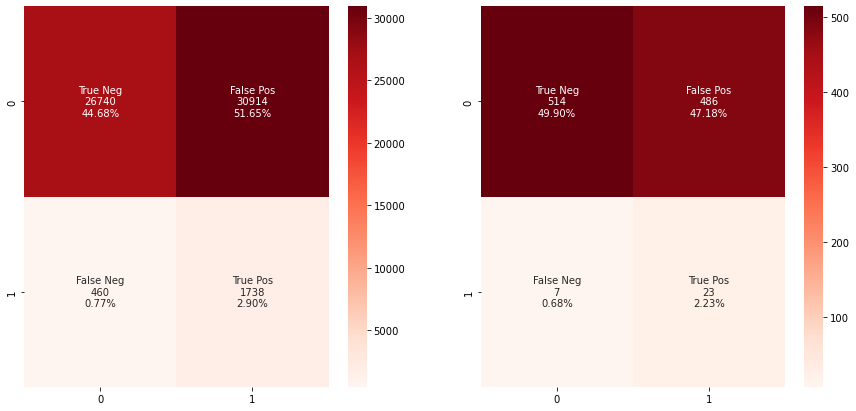

In [78]:
sgd.conf_mat(y_past,y_future_down)

In [79]:
y_future.value_counts()

0    3641
1      30
Name: label, dtype: int64

In [80]:
sgd_cl = SGDClassifier(random_state=RAND_STATE, max_iter=3000, learning_rate='optimal')
sgd = Model(
    X_train_sm, y_train_sm,
    X_past_df, X_future_down,
    sgd_cl, models['sgd']['params'], SGDClassifier,crss_vldtr=tscv)
sgd.params

Fitting 5 folds for each of 5 candidates, totalling 25 fits
{'penalty': 'l2', 'loss': 'log_loss', 'class_weight': 'balanced', 'alpha': 0.01}


{'alpha': 0.01,
 'average': False,
 'class_weight': 'balanced',
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'log_loss',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 42,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [82]:
from collections import Counter
# because only 1.5% of our data-set contains positive datapoints
counter = Counter(y_past)
estimate = np.sqrt(counter[0] / counter[1])

In [83]:
#kf = KFold(n_splits=5,shuffle = True, random_state = RAND_STATE)

# basic classifier constructor [for parameter search]
xgb_clf = XGBClassifier(
    objective = 'binary:logistic',
    use_label_encoder=False,
    #scale_pos_weight = estimate,
    random_state = RAND_STATE,)


xgb_params_in = {
    'n_estimators': stats.randint(150, 1000),
    'learning_rate': stats.uniform(0.01, 0.59),
    'subsample': stats.uniform(0.3, 0.6),
    'max_depth': [3, 4, 5, 6, 7],
    'colsample_bytree': stats.uniform(0.5, 0.4),
    #'scale_pos_weight' : stats.uniform(estimate,estimate**2),
    'min_child_weight': [1, 2, 3, 4]}

In [84]:
X_train_e = X_past_df.to_numpy()
y_train_np = np.ravel(y_past.to_numpy()).astype(np.int32)

In [85]:
xgb = Model(X_train_sm.to_numpy(), y_train_sm.to_numpy(),
    #X_train_e, y_train_np,
        X_train_e, X_future_down.to_numpy(),
        xgb_clf, xgb_params_in, XGBClassifier, crss_vldtr=tscv)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/antares/.pyenv/versions/mambaforge-4.10.1-4/envs/ih_DA_env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/antares/.pyenv/versions/mambaforge-4.10.1-4/envs/ih_DA_env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/antares/.pyenv/versions/mambaforge-4.10.1-4/envs/ih_DA_env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/antares/.pyenv/versions/mambaforge-4.10.1-4/envs/ih_DA

[01:47:19] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'colsample_bytree': 0.649816047538945, 'learning_rate': 0.5709214407818505, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 850, 'subsample': 0.6581100947678922}
[01:47:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117899018/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [86]:
xgb_feat_ranks_df = pd.DataFrame(np.ravel(xgb.tuned.feature_importances_),index=X_past_df.columns)
xgb_feat_ranks_df.columns = ['feature importance']
xgb_feat_ranks_df.sort_values(by='feature importance', ascending=False)

,feature importance
day_of_week_6.0,0.176312
neighbors,0.148482
looped,0.097293
length,0.091285
day_of_week_5.0,0.090564
income,0.086678
count,0.070211
weight,0.047956
day_of_week_3.0,0.045025
day_of_week_0.0,0.038456


In [87]:
xgb.score(y_past,y_future_down)

,Type,Accuracy,Precision,Recall,F1-Score
0,trn,0.936493,0.345121,0.812557,0.484470
0,tst,0.190291,0.031469,0.900000,0.060811
